# W207- Applied Machine Learning - Section 1

## Title: Random Acts of Pizza

## Team 2: Sartaj Singh Baveja, Tim Spittle, Jay Venkata & Angela Wu

**Table of Contents**

_To Do: Sub-sections to the table of contents_

1. [Overview](#overview)
2. [Data Preparation](#dataprep)  
2.1 [Initial Loading](#loading)  
2.2 [Data Cleaning](#datacleaning)
3. [Exploratory Data Analysis](#eda)  
3.1 [Features of Interest](#featinterest)  
3.2 [Variable correlation plot](#corrplot)  
3.3 [Request Time Variables](#time)  
3.4 [Requester Profile Variables](#profile)  
3.5 [Textual Features](#textual)  
4. [Baseline Model](#baseline)
5. [Feature Engineering](#featengg)
6. Model Selection
7. Error Analysis
8. Conclusion

<a id="overview"></a>

## 1. Overview

This competition contains a dataset with textual requests for pizza from the Reddit community - Random Acts of Pizza (https://www.reddit.com/r/Random_Acts_Of_Pizza/) together with their outcome (successful/unsuccessful) and meta-data. 

The dataset includes 5671 requests collected from the Reddit community between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request i.e whether its author received a pizza or not, is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.  

**Outcome of Project**: By getting a sense of the dynamics and factors of a request that most likely would influence its success, the team hopes to build a model capable of predicting which requests will garner a cheesy (but sincere!) act of kindness and will result in a pizza purchase.

<a id="dataprep"></a>

## 2. Data Preparation

In [1]:
# import sys
# !{sys.executable} -m pip install wordcloud
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install graphviz
# !{sys.executable} -m conda install graphviz

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
from pprint import pprint
import pandas as pd
import re
## Reference: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import time
import datetime
import scipy.stats as stat

# SK Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# https://xgboost.readthedocs.io/en/latest/index.html
import xgboost as xgb

# Source : https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# NMF (Non-Negative Matrix Factorization) to understand topic breakdown
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

### New packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


C:\Users\manat\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Each entry in pizza_request_dataset.json corresponds to one request (the first and only request by the requester).

### Fields in each request

| Field Name | Description |
| ---------- | ----------- |
| giver_username_if_known | Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). |
| in_test_set | Boolean indicating whether this request was part of our test set. |
| number_of_downvotes_of_request_at_retrieval | Number of downvotes at the time the request was collected. |
| number_of_upvotes_of_request_at_retrieval | Number of upvotes at the time the request was collected. |
| post_was_edited | Boolean indicating whether this post was edited (from Reddit). |
| request_id | Identifier of the post on Reddit, e.g. "t3_w5491". |
| request_number_of_comments_at_retrieval | Number of comments for the request at time of retrieval. |
| request_text | Full text of the request. |
| request_text_edit_aware | Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous". |
| request_title | Title of the request. |
| requester_account_age_in_days_at_request | Account age of requester in days at time of request. |
| requester_account_age_in_days_at_retrieval | Account age of requester in days at time of retrieval. |
| requester_days_since_first_post_on_raop_at_request | Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP). |
| requester_days_since_first_post_on_raop_at_retrieval | Number of days between requesters first post on RAOP and time of retrieval. |
| requester_number_of_comments_at_request | Total number of comments on Reddit by requester at time of request. |
| requester_number_of_comments_at_retrieval | Total number of comments on Reddit by requester at time of retrieval. |
| requester_number_of_comments_in_raop_at_request | Total number of comments in RAOP by requester at time of request. |
| requester_number_of_comments_in_raop_at_retrieval | Total number of comments in RAOP by requester at time of retrieval. |
| requester_number_of_posts_at_request | Total number of posts on Reddit by requester at time of request. |
| requester_number_of_posts_at_retrieval | Total number of posts on Reddit by requester at time of retrieval. |
| requester_number_of_posts_on_raop_at_request | Total number of posts in RAOP by requester at time of request. |
| requester_number_of_posts_on_raop_at_retrieval | Total number of posts in RAOP by requester at time of retrieval. |
| requester_number_of_subreddits_at_request | The number of subreddits in which the author had already posted in at the time of request. |
| requester_received_pizza | Boolean indicating the success of the request, i.e., whether the requester received pizza. |
| requester_subreddits_at_request | The list of subreddits in which the author had already posted in at the time of request. |
| requester_upvotes_minus_downvotes_at_request | Difference of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_minus_downvotes_at_retrieval | Difference of total upvotes and total downvotes of requester at time of retrieval. |
| requester_upvotes_plus_downvotes_at_request | Sum of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_plus_downvotes_at_retrieval | Sum of total upvotes and total downvotes of requester at time of retrieval. |
| requester_user_flair | Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83). |
| requester_username | Reddit username of requester. |
| unix_timestamp_of_request | Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA). |
| unix_timestamp_of_request_utc | Unit timestamp of request in UTC. |

<a id="loading"></a>

### 2.1 Initial Loading

In [3]:
## Load the training data in JSON
#os.chdir("/Users/jayvenkata/Documents/W207- Applied Machine Learning/Projects/Group Project")
with open(os.path.join(os.getcwd(), 'train.json')) as org_train_data_file:    
    org_train_data = json.load(org_train_data_file)

## Load the test data in JSON
with open(os.path.join(os.getcwd(), 'test.json')) as org_test_data_file:    
    org_test_data = json.load(org_test_data_file)

In [4]:
# Convert the training data in JSON to pandas dataframe
org_train_df_raw = pd.io.json.json_normalize(org_train_data)
org_train_df = pd.DataFrame.from_records(org_train_data)
# org_train_df.head()

Then, we split our data into training and development. Further, we make sure that both sets mirror the average success rate in our dataset of 24.6%

In [5]:
## Split the original training data into training and development
np.random.seed(0)
train_df, dev_df = train_test_split(org_train_df, test_size = 0.4, stratify=org_train_df['requester_received_pizza'])

train_labels = train_df.requester_received_pizza.astype(int).values
dev_labels = dev_df.requester_received_pizza.astype(int).values

## Verify the stratefication works
print("Sucess Rate (training data): " + str(round(train_df["requester_received_pizza"].mean(),2)))
print("Sucess Rate (dev data): " + str(round(dev_df["requester_received_pizza"].mean(),2)))

Sucess Rate (training data): 0.25
Sucess Rate (dev data): 0.25


In [6]:
# Convert the test data in JSON to pandas dataframe
test_df = pd.DataFrame.from_records(org_test_data)
# test_df.head()

In [7]:
train_columns = list(train_df.columns.values)
test_columns = list(test_df.columns.values)

var_table_overlap = pd.DataFrame(columns = ['Variable', 'Train', 'Test'])
train_var_series = pd.Series(train_columns, name='Variable')
test_var_series = train_var_series.isin(test_columns)
var_table_overlap['Variable'] = train_columns
var_table_overlap['Train'] = True
var_table_overlap['Test'] = test_var_series
var_table_overlap.sort_values(by = ['Test'])

,Variable,Train,Test
10,requester_account_age_in_days_at_retrieval,True,False
18,requester_number_of_posts_at_retrieval,True,False
22,requester_received_pizza,True,False
16,requester_number_of_comments_in_raop_at_retrieval,True,False
14,requester_number_of_comments_at_retrieval,True,False
12,requester_days_since_first_post_on_raop_at_ret...,True,False
25,requester_upvotes_minus_downvotes_at_retrieval,True,False
27,requester_upvotes_plus_downvotes_at_retrieval,True,False
20,requester_number_of_posts_on_raop_at_retrieval,True,False
6,request_text,True,False


From the above, we will focus only on the columns that are present in both the datasets and disregard the others. This is because
- *_at_retrieval doesn't relate to the concept of real-time as much as *_at_request variables do
- user_flair not required since this is after / we have received_pizza variable
- post_was_edited / request_text - better variable is the request_text_edit_aware since it captures the text even when a post is edited
- requester_received_pizza - that's the variable that needs to be predicted

In [8]:
# Summary of the training data
train_df.describe()

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,request_number_of_comments_at_retrieval,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,...,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,...,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2.424000e+03,2.424000e+03
mean,2.490924,6.243399,2.852310,257.076562,761.135408,15.854911,519.375076,117.129538,289.739274,0.609323,...,40.856848,0.060231,1.224422,18.267739,1134.673267,2684.942244,3534.171617,7481.891089,1.342733e+09,1.342729e+09
std,3.159131,10.324260,4.519556,308.291897,334.844271,68.349921,266.825980,197.255766,359.259651,3.373627,...,81.979290,0.328333,0.576724,22.037967,2870.852260,5265.463552,18798.464623,25363.399331,2.323524e+07,2.323456e+07
min,0.000000,0.000000,0.000000,0.000000,45.291562,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-173.000000,-173.000000,0.000000,0.000000,1.297723e+09,1.297723e+09
25%,1.000000,2.000000,0.000000,2.893015,524.856794,0.000000,280.503828,0.000000,7.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,3.000000,22.000000,8.000000,50.000000,1.320282e+09,1.320279e+09
50%,2.000000,4.000000,1.000000,158.299797,754.348223,0.000000,522.899485,24.000000,112.500000,0.000000,...,13.000000,0.000000,1.000000,11.000000,174.500000,699.000000,361.000000,1269.500000,1.342686e+09,1.342682e+09
75%,3.000000,7.000000,4.000000,388.884178,902.263547,0.000000,776.226670,142.000000,475.000000,0.000000,...,46.000000,0.000000,1.000000,27.000000,1167.000000,3305.250000,2307.750000,6921.750000,1.364291e+09,1.364288e+09
max,47.000000,276.000000,61.000000,2809.750787,2879.276319,739.771007,1025.407593,994.000000,1000.000000,88.000000,...,999.000000,5.000000,6.000000,162.000000,87911.000000,108977.000000,789287.000000,883299.000000,1.381373e+09,1.381345e+09


In [9]:
# Summary of the development data
dev_df.describe()

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,request_number_of_comments_at_retrieval,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,...,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,...,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1.616000e+03,1.616000e+03,1.616000e+03,1.616000e+03
mean,2.324876,6.086015,2.899134,250.851605,752.528689,17.260219,518.420399,112.051361,288.955446,0.698639,...,41.594059,0.068688,1.261139,17.790223,1198.189975,2773.441832,4.056832e+03,8.247335e+03,1.342974e+09,1.342971e+09
std,2.804733,11.352638,5.014811,295.647286,330.340418,73.983087,269.516709,187.277828,354.743297,3.473583,...,79.017479,0.321929,0.640143,21.279765,4712.831861,7519.415498,3.375351e+04,5.358297e+04,2.347930e+07,2.347862e+07
min,0.000000,0.000000,0.000000,0.000000,75.817535,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-39.000000,-16.000000,0.000000e+00,1.000000e+00,1.306186e+09,1.306183e+09
25%,1.000000,2.000000,0.000000,4.615590,519.981386,0.000000,276.464363,0.000000,8.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,3.000000,21.000000,9.000000e+00,5.500000e+01,1.320863e+09,1.320863e+09
50%,2.000000,4.000000,1.000000,154.850752,750.433814,0.000000,534.842367,24.000000,116.500000,0.000000,...,13.000000,0.000000,1.000000,11.000000,175.000000,714.000000,3.350000e+02,1.298000e+03,1.342154e+09,1.342151e+09
75%,3.000000,7.000000,4.000000,391.212520,896.280307,0.000000,776.019974,138.000000,483.000000,0.000000,...,46.000000,0.000000,1.000000,27.000000,1158.000000,3301.750000,2.300750e+03,6.745250e+03,1.365002e+09,1.364998e+09
max,32.000000,345.000000,61.000000,1992.518657,2733.297060,785.457685,927.447442,990.000000,1000.000000,77.000000,...,972.000000,4.000000,9.000000,186.000000,155010.000000,223708.000000,1.286864e+06,2.046482e+06,1.381552e+09,1.381523e+09


<a id="datacleaning"></a>

### 2.2 Data Cleaning

#### De-duplicate

In [10]:
# train_df.duplicated()
### TS NOTE ### - values stored as lists - not going to go through with fixing this, would prefer to just assume the data is de-duplicated

#### Remove outliers

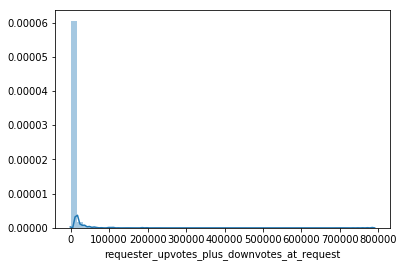

In [11]:
# Remove outlier up_plus_down
sns.distplot(train_df.loc[:,'requester_upvotes_plus_downvotes_at_request']);

In [12]:
train_df.nlargest(3, 'requester_upvotes_plus_downvotes_at_request')

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
325,N/A,1,4,False,t3_1h9ylg,3,,,"(request) Never had to do this before, but my ...",276.103021,...,False,"[AdviceAnimals, AskReddit, AskScienceFiction, ...",87911,108977,789287,883299,None,kevonicus,1.372461e+09,1.372457e+09
4013,N/A,3,14,1.37788e+09,t3_1lefgo,5,"We dont tend to have fast food pizza, we make ...","We dont tend to have fast food pizza, we make ...","[Request] No manipulative sob story, Id just l...",473.575671,...,False,"[4chan, AdviceAnimals, Art, AskReddit, DIY, Fe...",23593,25513,194891,199437,None,BisFitty,1.377876e+09,1.377872e+09
1950,N/A,1,6,False,t3_13n4wc,3,Held a contest for a pizza/gift card \nhttp://...,Held a contest for a pizza/gift card \nhttp://...,[Request] Need help buying gift card for a USA...,444.186377,...,True,"[AskReddit, CheapShark, Fixxit, IAmA, Random_A...",23293,49748,184831,304254,shroom,EvilCyborg10,1.353628e+09,1.353628e+09


In [13]:
# Such a long right tail and the person with the most up_plus_down is not even the most frequent poster or oldest account, just a troll. Remove
print(train_df.shape)
train_df = train_df[train_df.requester_upvotes_plus_downvotes_at_request != 789287]
print(train_df.shape)

(2424, 32)
(2423, 32)


#### Convert variables

In [14]:
# Received as numeric
train_df['requester_received_pizza_int'] = train_df.requester_received_pizza.astype(int)

<a id="eda"></a>

## 3. Exploratory Data Analysis  

<a id="featinterest"></a>

### 3.1 Features of Interest

Success of these reddit requests depend on factors like who is asking, how they are asking, and when are they asking. This will help us understand the attributes of the best formulated requests and why certain ones are promoted higher than others.

#### Meta-Data Features

_General Note_ Many features not present in test data are not known at time of posting, therefore they will be ignored for this analysis. This includes the "at retrieval" statistics, RAOP "user flair", and raw (i.e. non-"edit aware") request text.  

**Time**  
Time is a very basic but important feature to include. Logically, there are likely times of day when more users are active on RAOP and this may have varied effects on the behaviors we observe:  
- More users requesting may make the environment more competitive (i.e. harder for a single post to stand out) 
- Conversely, more users giving may make likelihood of success higher (all things equal).  
    - _NOTE_, however, that we cannot observe the time of giving in this dataset.  

These periods of increased requests/gives may not coincide with one another and it will be important to understand the periods of high and low activity relative to UTC; there may be multiple shifts throughout a day coinciding with higher activity in different countries/time zones around the globe.  

**Requester Profile**    
In attempting to predict likelihood of fulfillment for a request on RAOP based on featues related to the profile of the requester, we believe it may be important to make a distinction between: 
- _Primary_ profile features (i.e. features which an average reader/potential giver on RAOP may see/consider)
    - Age of account - whether it appears to be a new/throwaway account or a longtime veteran  
    - Number and frequency of requests - if the requester has made requests before
- _Secondary_ features (i.e. extended detail about requester activity on Reddit that a potential giver might not see, and therefore it wouldn't have as much influence on their likelihood of fulfilling the request or not)  
    - Comments made
    - Posts
    - Sub-Reddits in which they participate
    - Upvotes/Downvotes

**Community Effects (Secondary)**  
The training data constains featues related to the reactions to a request on RAOP (upvotes/downvotes/comments) which, while not available in the test data and not appropriate for success classifcation algorithm (given that we don't know this info at time of the request nor do we know if this activity happened before/after the request was fulfilled), positive or contentious reactions to posts may be correlated with success/fulfillment. Therefore, it may be worhtwhile to explore these relationships and, if useful, a sensitivity analysis that predicts these metrics to provide additional insight into predictive features.  

<a id="corrplot"></a>

### 3.2 Variable correlation plot

In [15]:
# Create new dataframe with only the shared columns
train_w_test = train_df[test_df.columns.values]

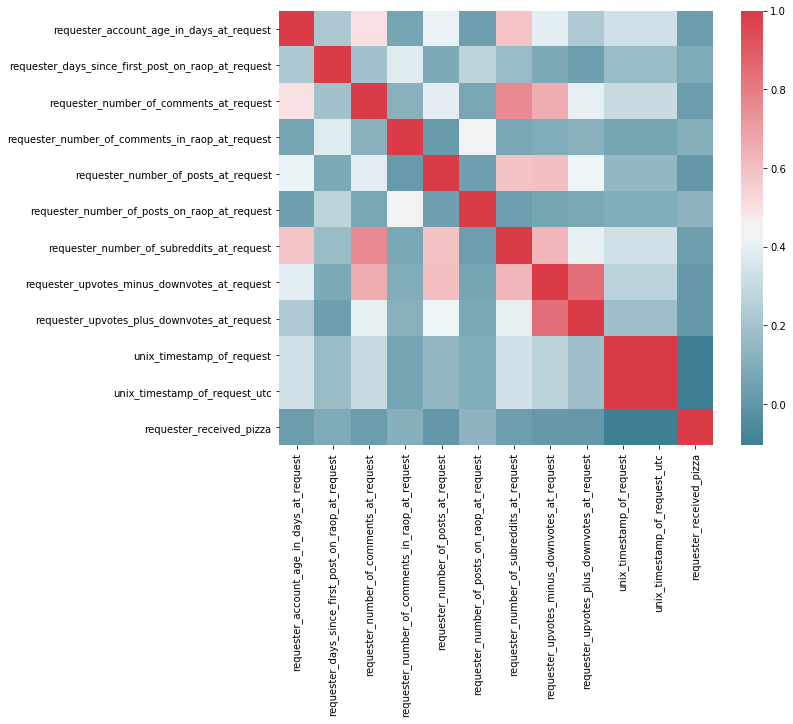

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
train_w_test['requester_received_pizza'] = train_df['requester_received_pizza']
corr = train_w_test.corr()
sns.heatmap(corr, 
            mask=np.zeros_like(corr, dtype = np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap = True),
            square=True, 
            ax=ax)

Notes

1. Request timing- Day of the week and time of the day
2. Text Field length
3. Upvotes vs Downvotes  
4. Requester account vs activity - evaluate the various requester feature differences between those whose requests were fulfilled, and those whose requests were not
5. Perform Topic Modeling using LDA or NMF to identify most common topics and then, we'll be able to group them into categories (https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730) 
6. Word clouds around successful/unsuccessful words  

<a id="time"></a>

### 3.3 Request Time Variables

Let's break down Request Time into 4 Trends and do a deeper dive into each of these: 

1. Frequency of Requests over Months
2. Fulfillment of Requests over Months
3. Fulfillment - Day of the Week
4. Fulfillment - Time of the Day

#### 1. Frequency of Requests over Months

This would show us how many requests for Pizza posts occurred over the entire duration of the dataset between 2011 and 2013. 

Text(0,0.5,'Number of Posts/ Requests')

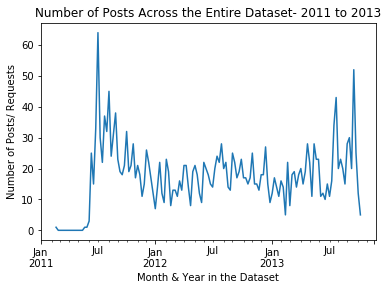

In [17]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_df["unix_timestamp_of_request"], unit = 's')
d.index = d['datetime']
d['datetime'].resample('W').count().plot().set_title('Number of Posts Across the Entire Dataset- 2011 to 2013')
plt.xlabel('Month & Year in the Dataset')
plt.ylabel('Number of Posts/ Requests')

We can see from the above graph that there were a lot of posts around the 6 month mark of the reddit community opening until about July 2011. There also seems to be a spike towards the end of the dataset- July & August 2013. 

#### 2. Fulfillment of Requests over Months

This would show us how many Pizza givers there were over the entire duration of the dataset between 2011 and 2013. 

Text(0,0.5,'Percentage of Fulfilled Requests')

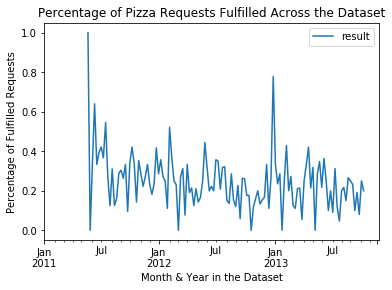

In [18]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_df["unix_timestamp_of_request"], unit = 's')
train_labels = train_df["requester_received_pizza"]
d['result'] = train_labels
d.index = d['datetime']
d.resample('W').mean().plot().set_title("Percentage of Pizza Requests Fulfilled Across the Dataset")
plt.xlabel('Month & Year in the Dataset')
plt.ylabel('Percentage of Fulfilled Requests')

The above plot shows that request fulfillment was at its highest at the start of the group. However despite a few peaks during the Winter (Dec-Jan season) the overall fulfillment % has fallen over time. This shows that people are more willing to give during the Holiday season.

#### 3. Day of the Week 

Let's now look into whether the Day of the Week played a role in Pizza request fulfillments.

In [19]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
d['Day_of_Week'] = d['datetime'].dt.weekday_name
week_df = d.groupby('Day_of_Week').agg(['mean', 'count']).reindex(days)
week_df ### NOTE ### - just returning pandas dataframe has cleaner output than wrapping in print()

result      
                 mean count
Day_of_Week                
Monday       0.259669   362
Tuesday      0.235127   353
Wednesday    0.217604   409
Thursday     0.302053   341
Friday       0.259615   312
Saturday     0.204473   313
Sunday       0.246246   333

The fulfillment rate varies between 21.7% (Wednesday) to 30.2% (Thursday). 
This seems like a reasonably distinguishing feature that should be considered for our model. 

#### 4. Time of the Day

Let's now look into whether the Time of the Day played a role in Pizza request fulfillments. 

Text(0,0.5,'Number of Requests')

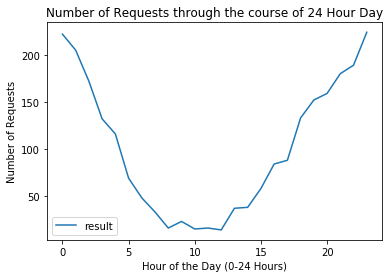

In [20]:
d['hour'] = d['datetime'].dt.hour
d[['hour', 'result']].groupby('hour').agg('count').plot().set_title("Number of Requests through the course of 24 Hour Day")
plt.xlabel('Hour of the Day (0-24 Hours)')
plt.ylabel('Number of Requests')

We can see from the above graph that the number of posts/ requests spikes up considerably during the night times- Between 8 PM and 3 AM with a peak around Midnight. 

Text(0,0.5,'Percentage of Fulfilled Requests')

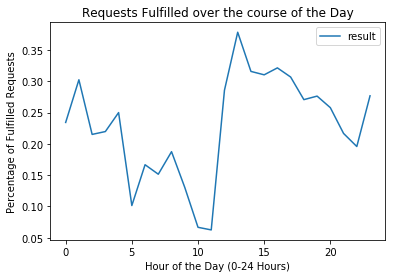

In [21]:
d[['hour', 'result']].groupby('hour').agg('mean').plot().set_title("Requests Fulfilled over the course of the Day")
plt.xlabel('Hour of the Day (0-24 Hours)')
plt.ylabel('Percentage of Fulfilled Requests')

We can see from the above graph that the number of fulfilled requests varies from 6% to 38% depending on the time of the day.

### Visualize requests and granted requests over time

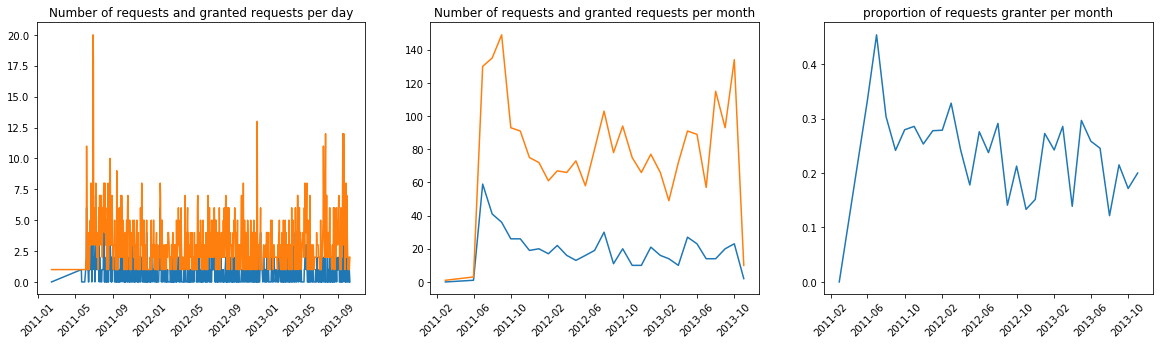

In [22]:
# Data setup
train_w_test = train_w_test.assign(
    unix_timestamp_of_request = pd.to_datetime(
        train_w_test.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(
        train_w_test.unix_timestamp_of_request_utc, unit = "s"))

ts = pd.DataFrame({'granted requests':train_df.requester_received_pizza.tolist(),
                  'requests':[1] * train_df[['requester_received_pizza']].shape[0]},
                  index = train_w_test.unix_timestamp_of_request.dt.date.tolist())

ts = ts.groupby(ts.index).sum()

ts_month = pd.DataFrame({'granted requests':train_df.requester_received_pizza.tolist(),
                  'requests':[1] * train_df[['requester_received_pizza']].shape[0]},
                index = (train_w_test.unix_timestamp_of_request.dt.date + pd.offsets.MonthBegin(0)).tolist())

ts_month = ts_month.groupby(ts_month.index).sum()

# Plots
# 1. By day
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(ts)
plt.title("Number of requests and granted requests per day")
plt.xticks(rotation=45)

# 2. By Month
plt.subplot(1,3,2)
plt.plot(ts_month)
plt.title("Number of requests and granted requests per month")
plt.xticks(rotation=45)

# 3. By Month (proportion)
plt.subplot(1,3,3)
plt.plot(ts_month.assign(prop_granted = ts_month['granted requests'] / ts_month['requests'])['prop_granted'])
plt.title("proportion of requests granter per month")
plt.xticks(rotation=45)

plt.show()

<a id="profile"></a>

### 3.4 Requester Profile Variables

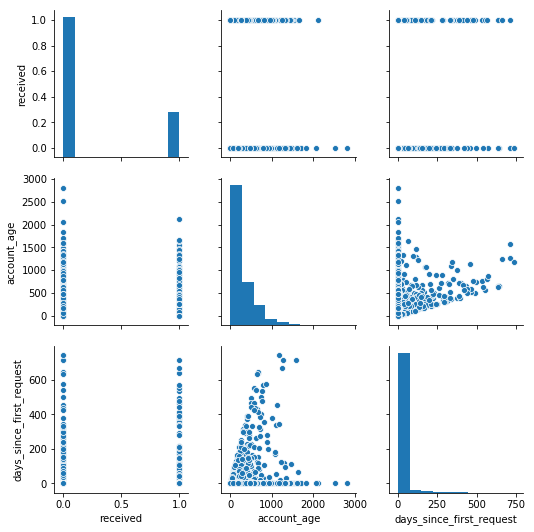

In [23]:
train_profile = pd.DataFrame({'received':train_df.requester_received_pizza_int.tolist(),
                              'account_age':train_df.requester_account_age_in_days_at_request.tolist(),
                              'days_since_first_request':train_df.requester_days_since_first_post_on_raop_at_request.tolist()})

sns.pairplot(train_profile);

NOTES:
- Interesting that many 0-day accounts and first time posters
    - For account age we might want to isolate 0 and then stratify by a few key buckets (max of 8 years is a long time)
    - For days_since_post defintely create first time vs repeat
        - Also take a look at long right tail (500 seems ridiculous)
- floor on mid-right plot shows that some people post to raop on first day of account then continue on until posting again

NOTES:
- Big Up/Down vote outlier - going to remove, doesn't seem reasonable (even if there is an explanation for who that person is and why they have so much voting)

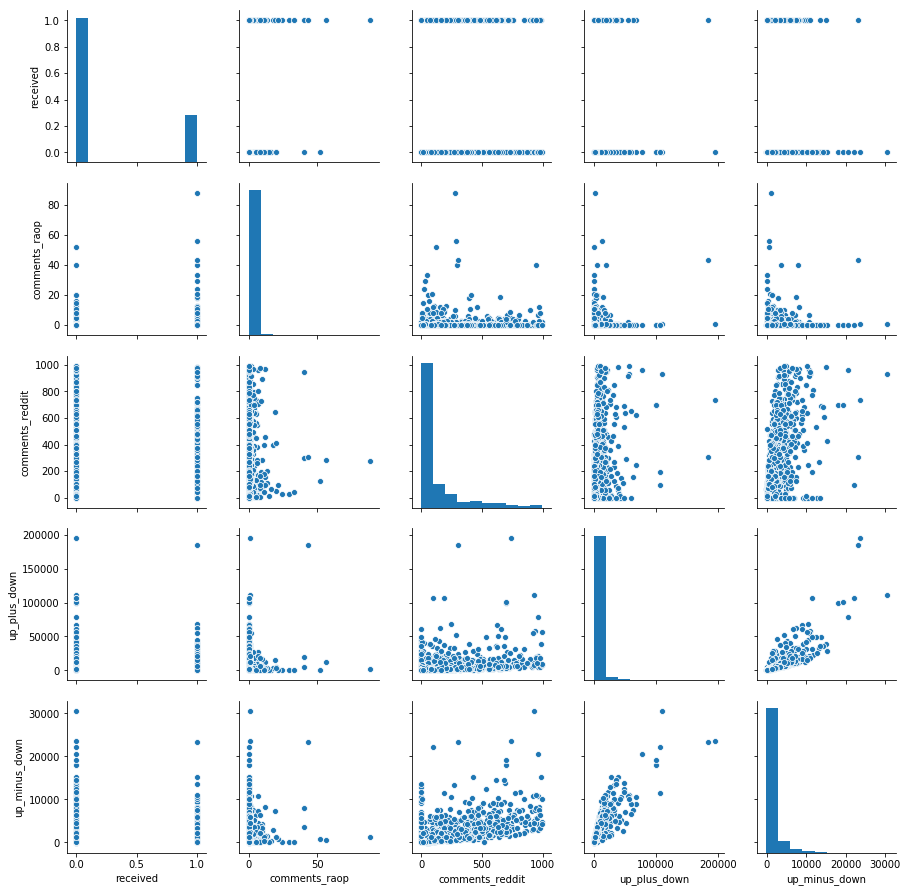

In [24]:
# Comments, Reddit and RAOP (not posts - it aligns too much with days since last post, very few observations)
# Up/Down Votes
train_part = pd.DataFrame({'received':train_df.requester_received_pizza_int.tolist(),
                           'comments_raop':train_df.requester_number_of_comments_in_raop_at_request.tolist(),
                           'comments_reddit':train_df.requester_number_of_comments_at_request.tolist(),
                           'up_plus_down':train_df.requester_upvotes_plus_downvotes_at_request.tolist(),
                           'up_minus_down':train_df.requester_upvotes_minus_downvotes_at_request.tolist()})

sns.pairplot(train_part);

NOTES:
- Lurkers: 
    - Tons of 0 values on participation metrics
    - Big leading spike in comments relative to up/downvotes
    - Comments in RAOP not parituclarly correlated with comments outside of RAOP 
- Only noticeable correlation with received is RAOP participation

<a id="textual"></a>

### 3.5 Textual Features

#### a) Non Negative Matrix Factorization

**From Stanford Paper**

To identify the different kinds of stories we draw on previous literature suggesting that narratives can be automatically extracted using topic modeling and related techniques. We therefore perform topic modeling through non negative matrix factorization (NMF) of a TF-IDF weighted bag-of-words representation of the requests in our dataset.

We additionally enforce sparsity on the topic distribution for each request to shape the topics in a way that captures most of a given request, and restrict ourselves to nouns. We choose to use 10 topics and use a SVD-based initialization for NMF.

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2, 
                                   max_features=1000, 
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train_df['request_text_edit_aware'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nmf = NMF(n_components=10, 
          random_state=1, 
          alpha=0.1, 
          l1_ratio=0.5, 
          init='nndsvd').fit(tfidf)

# Print the 5 most common topics with their count
topics_vector = np.argmax(nmf.transform(tfidf), axis=1)
top_5 = Counter(topics_vector).most_common(5)
print('Top five most common topics with counts: {}'.format(str(top_5)))

# Display topics with the top 10 words in each topic
def display_topics(model, feature_names, no_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_words - 1:-1]]))

display_topics(nmf, tfidf_feature_names, 15)

Top five most common topics with counts: [(0, 1149), (1, 224), (3, 153), (8, 148), (2, 142)]

Topic 0:
food ve help money job time work day got days going know today new make

Topic 1:
pizza like thanks buy tonight hut craving ll send papa thank good nice awesome random

Topic 2:
com http imgur jpg www reddit png picture lt proof pic youtube gt use user

Topic 3:
pay forward promise soon ll friday able paycheck thanks cash possible gladly better happy broke

Topic 4:
hungry broke help pretty dont send thanks eat feeling super roommates food right pics ll

Topic 5:
love pizza forever says title pie tonight reading favor night surprise subreddit feeling broke family

Topic 6:
just want story sob don moved pizza got tired started craving sad know new school

Topic 7:
really appreciate right don use craving haven pizza broke wednesday afford story lately today hot

Topic 8:
paid week friday favor help till return don appreciated rent ramen title buy says won

Topic 9:
student college broke

The Top 5 topics can be put under the following categories
- Topic 0: Job
- Topic 1: Pizza / Craving
- Topic 3: Reciprocity
- Topic 8: Money
- Topic 2: Proof / Validation

#### b) LDA (Latent Dirichlet Allocation)

LDA is based on probabilistic graphical modeling while NMF relies on linear algebra.

A tf-idf transformer is applied to the bag of words matrix that NMF must process with the TfidfVectorizer. LDA on the other hand, being a probabilistic graphical model (i.e. dealing with probabilities) only requires raw counts, so a CountVectorizer is used. Stop words are removed and the number of terms included in the bag of words matrix is restricted to the top 1000.

In [26]:
# Source : https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df = 0.95, 
                                min_df = 2, 
                                max_features = 1000, 
                                stop_words='english')
tf = tf_vectorizer.fit_transform(train_df['request_text_edit_aware'].tolist())
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
lda = LatentDirichletAllocation(n_components=10, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf)

# Print the 5 most common topics with their count
topics_vector = np.argmax(lda.transform(tf), axis=1)
top_5 = Counter(topics_vector).most_common(5)
print('Top five most common topics with counts: {}'.format(str(top_5)))

no_top_words = 15
display_topics(lda, tf_feature_names, no_top_words)

Top five most common topics with counts: [(0, 1827), (9, 335), (5, 52), (2, 51), (3, 49)]

Topic 0
pizza just really help food ve don thanks like money job time week pay love

Topic 1
butter uh peanut huh sweet stranger idea domino phone pizza complete buying 30 bag rock

Topic 2
title says pizza love edit location pretty eat forgot works cash time mom help pregnant

Topic 3
card reddit pizza im credit account www code paypal debit com verification cash http thanks

Topic 4
com http imgur jpg www pizza picture pic proof dog vet png video hungry pics

Topic 5
pizza draw ll hungry help pretty watch dont song write dominos try choice different youtube

Topic 6
reasons number dorm remember appreciated picky greatly roommate peace head crying needed pizza best hurt

Topic 7
amp paycheck ve pay rent pizza rice busy forward living just fiance bills help 24

Topic 8
pizza papa hut johns dominos john like dominoes gift husband domino 11 deliver nearby gt

Topic 9
money got pay food week pizza w

The Top 5 topics can be put under the following categories
- Topic 0: Money / Job
- Topic 9: Money / Job
- Topic 3: Verification
- Topic 5: Pizza
- Topic 2: General

#### c) Word Visualization

Through this, we want to visualize the common bigrams and compare them for successful and unsuccessful requests. We choose bigrams as unigrams alone makes little sense and trigrams are too rare to be useful. From these visuals we can start to get an idea of potential differentiatiors in terms of post content that might make a difference to whether a user gets pizza or not. 

In [27]:
from wordcloud import WordCloud, STOPWORDS

def word_join(string,joiner=' '):
    return joiner.join(string.split())

joined_words = np.vectorize(word_join)

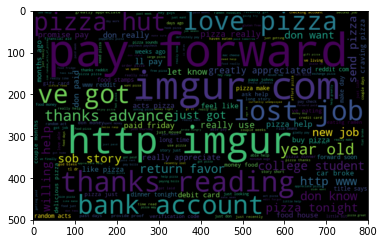

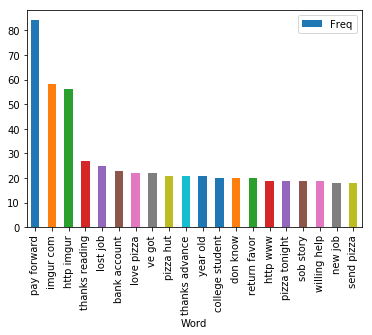

In [28]:
# Create WordCloud for Successful Requests

# Get text from variables where received pizza val was true
successful_edit_text = train_df[train_df['requester_received_pizza'] == True]['request_text_edit_aware']

CV = CountVectorizer(stop_words='english',ngram_range=(2,2))
cv_fit = CV.fit_transform(successful_edit_text)

vocab = joined_words(CV.get_feature_names())

frequency = list(cv_fit.toarray().sum(axis=0))
word_score = dict(zip(vocab,frequency))
wc = WordCloud(max_words = 200,
               stopwords = set(STOPWORDS),
               height = 500,
               width = 800).fit_words(word_score)

plt.imshow(wc, interpolation='bilinear')

sorted_word_score = sorted(list(zip(vocab,frequency)), key=lambda x: -x[1])
got_pizza = pd.DataFrame(sorted_word_score[:20], columns = ['Word', 'Freq'])
got_pizza.plot.bar(x = 'Word', y = 'Freq')

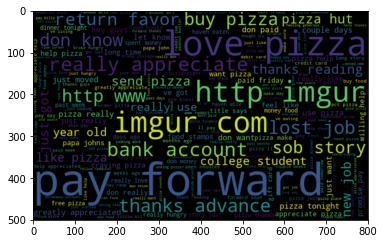

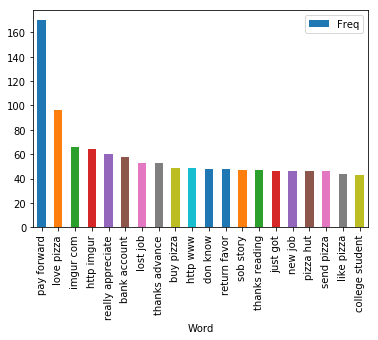

In [29]:
# Get text from variables where received pizza val was true
unsuccessful_edit_text = train_df[train_df['requester_received_pizza'] == False]['request_text_edit_aware']

CV2 = CountVectorizer(stop_words='english',ngram_range=(2,2))
cv_fit2 = CV2.fit_transform(unsuccessful_edit_text)

vocab2 = joined_words(CV2.get_feature_names())

frequency2 = list(cv_fit2.toarray().sum(axis=0))
word_score2 = dict(zip(vocab2,frequency2))
wc2 = WordCloud(max_words = 200,
                stopwords = set(STOPWORDS),
                height = 500,
                width = 800).fit_words(word_score2)

plt.imshow(wc2, interpolation='bilinear')

sorted_word_score2 = sorted(list(zip(vocab2,frequency2)), key=lambda x: -x[1])
no_pizza = pd.DataFrame(sorted_word_score2[:20], columns = ['Word', 'Freq'])
no_pizza.plot.bar(x = 'Word', y = 'Freq')

There are some interesting differences such as amongst common phrases, what's interesting is how those who didn't get pizza mentioned "love pizza" and "pay forward" more often. Further, they also include images in the text

#### d) From the above, look at unigrams now

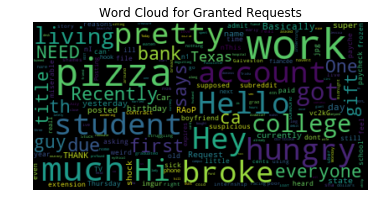

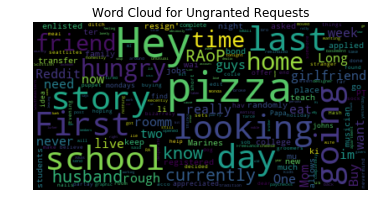

In [30]:
import matplotlib as mpl

granted_requests = train_df[train_df['requester_received_pizza'] == True]
ungranted_requests = train_df[train_df['requester_received_pizza'] == False]

stopwords = set(STOPWORDS)

wc2 = WordCloud(max_words = 200,
               height = 500,
               width = 800).fit_words(word_score2)

wordcloud = WordCloud(stopwords=stopwords,
                      max_words=300,
                      max_font_size=50, 
                      random_state=42).generate(str(granted_requests['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Granted Requests")
plt.show()

wordcloud = WordCloud(stopwords=stopwords,
                      max_words=300,
                      max_font_size=50, 
                      random_state=42).generate(str(ungranted_requests['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Ungranted Requests")
plt.show()

<a id="baseline"></a>

## 4. Baseline Model

In [31]:
### TODO: 
    # Create all feature dfs separately then combine? or sequentially pass and add?

# Use standard CountVectorizer to transform the training data and dev data 
vectorizer = CountVectorizer() 
train_data = vectorizer.fit_transform(train_df['request_text_edit_aware'])
dev_data = vectorizer.transform(dev_df['request_text_edit_aware'])

list_vars_keep = ['requester_upvotes_plus_downvotes_at_request', 
                  'requester_upvotes_minus_downvotes_at_request',
                  'requester_number_of_comments_in_raop_at_request',
                  'unix_timestamp_of_request',
                  'requester_days_since_first_post_on_raop_at_request',
                  'requester_account_age_in_days_at_request']

train_df_lim = train_df[list_vars_keep]
train_text_df = pd.DataFrame(train_data.toarray())
train_concat = pd.concat([train_df_lim.reset_index(), train_text_df], axis = 1)
train_concat = train_concat.drop(columns = ['index'])

dev_df_lim = dev_df[list_vars_keep]
dev_text_df = pd.DataFrame(dev_data.toarray())
dev_concat = pd.concat([dev_df_lim.reset_index(), dev_text_df], axis = 1)
dev_concat = dev_concat.drop(columns = ['index'])

print(train_df_lim.shape)
print(train_text_df.shape)
print(train_concat.shape)

print(dev_df_lim.shape)
print(dev_text_df.shape)
print(dev_concat.shape)

(2423, 6)
(2423, 9489)
(2423, 9495)
(1616, 6)
(1616, 9489)
(1616, 9495)


In [122]:
def roc_plot(dev_labels, pred_dev_prob):
    fpr, tpr, threshold = metrics.roc_curve(dev_labels, pred_dev_prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def confusion_plot(confusion_matrix, target_names):
    
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
def standard_output(labels_in, pred_prob_in, pred_class_in):
    # AUC
    print("AUC score = {} \n".format(roc_auc_score(labels_in, pred_class_in, average = 'micro')))
    # Classification Report
    print(classification_report(labels_in, pred_class_in))
    # Confusion Matrix
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    confusion_plot(confusion_matrix = confusion_matrix(y_true = labels_in, 
                                                       y_pred = pred_class_in), 
                   target_names = ["No Pizza", "Pizza"])
    # ROC
    plt.subplot(1,2,2)
    roc_plot(labels_in, pred_prob_in)

### 4.1 - ZeroR Baseline

Zero R rule = apply highest class % to all  
(No pizza received)

AUC score = 0.5 

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1218
           1       0.00      0.00      0.00       398

   micro avg       0.75      0.75      0.75      1616
   macro avg       0.38      0.50      0.43      1616
weighted avg       0.57      0.75      0.65      1616



C:\Users\manat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


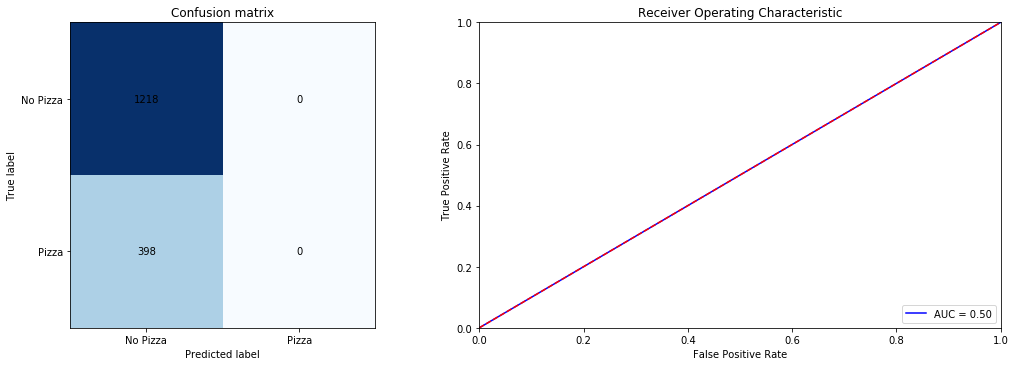

In [123]:
# dev_labels vs. vector of 1/0 based on guessing all 1/0 (majority %)
zeror_prob = np.repeat(train_df["requester_received_pizza"].mean(), len(dev_labels))
zeror_class = np.repeat(round(train_df["requester_received_pizza"].mean(),0), len(dev_labels))

standard_output(labels_in = dev_labels, pred_prob_in = zeror_prob, pred_class_in = zeror_class)

### 4.2 NaiveBayes Baseline

C:\Users\manat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 5.156363636363636}
AUC score = 0.5668995634989398 

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1218
           1       0.00      0.00      0.00       398

   micro avg       0.75      0.75      0.75      1616
   macro avg       0.38      0.50      0.43      1616
weighted avg       0.57      0.75      0.65      1616

Confusion Matrix 
[[1216    2]
 [ 398    0]]


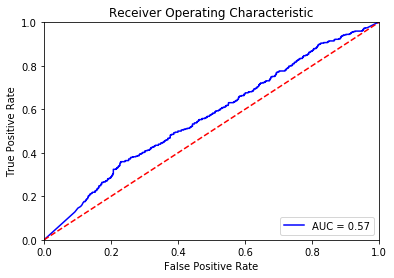

In [34]:
# Create MultinomialNB
mnb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(mnb, parameters)

# train the MultinomialNB
clf.fit(train_data, train_labels)

pred_dev_prob = clf.predict_proba(dev_data)[:,0]
pred_dev_labels = clf.predict(dev_data)

print(clf.best_params_)
print("AUC score = {} \n".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))
print(classification_report(dev_labels, pred_dev_labels))

### HEADERS
print("Confusion Matrix \n{}".format(confusion_matrix(dev_labels, pred_dev_labels)))

roc_plot(dev_labels, pred_dev_prob)

With an auc of .57, the Naive Bayes baseline model does slightly better than randomly guessing (auc of .5). 
The confusion matrix shows that the model fails to predict any fulfilled requests.

### 4.3 Logistic Regression Baseline

C:\Users\manat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Baseline: the best f1 score = 0.7054 

Value of Sum of squared weight Value is = 366.6 

AUC score = 0.444395623437384 
 

Confusion Matrix 
[[1050  168]
 [ 308   90]]


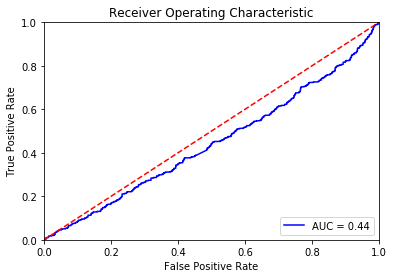

In [35]:
# Let's leverage the Standard CountVectorizer transformations done during the Naive Bayes Baseline above
#train_data/ train_labels & dev_data/ dev_labels

#Create Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(train_data,train_labels)
logit_preds = log_reg.predict(dev_data)
logit_dev_prob = log_reg.predict_proba(dev_data)[:,0]

log_scores = [] 
log_scores.append(metrics.f1_score(dev_labels, logit_preds, average='micro'))

log_weights = [] #For the sum of the squared weight values 
log_weights.append(np.sum(log_reg.coef_**2))

print("Logistic Baseline: the best f1 score =","{:.4f}".format(np.max(log_scores)),"\n")
print("Value of Sum of squared weight Value is =","{:.1f}".format(np.max(log_weights)),"\n")
print("AUC score = {} \n".format(roc_auc_score(dev_labels, logit_dev_prob, average='micro')),"\n")
print("Confusion Matrix \n{}".format(confusion_matrix(dev_labels, logit_preds)))
roc_plot(dev_labels, logit_dev_prob)

With an auc of .44, the logistic baseline model does worse than randomly guessing (auc of .5). 
The confusion matrix shows that the model leans more towards the False positive than the True positive rate. 

### 4.4 XGBoost Baseline

In [36]:
# NOTE: can still use numeric/continuous variable
train_xgb = xgb.DMatrix(train_concat, label = train_labels)
dev_xgb = xgb.DMatrix(dev_concat)

# Specify parameters via map
xgb_params = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
xgb_num_round = 2
xgb_base = xgb.train(xgb_params, train_xgb, xgb_num_round)

# Prediction
xgb_dev_prob = xgb_base.predict(dev_xgb)

C:\Users\manat\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\manat\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


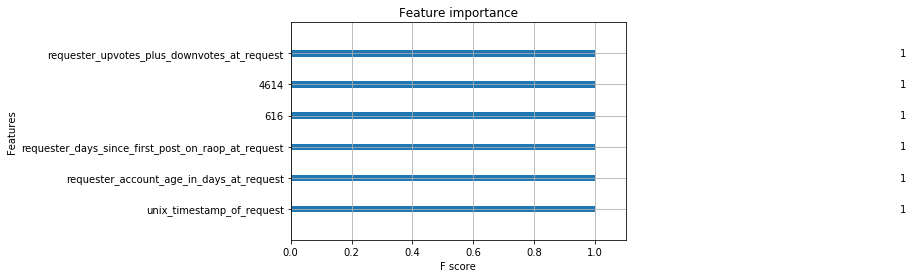

In [37]:
xgb.plot_importance(xgb_base)
# xgb.plot_tree(xgb_base, num_trees=1)
### REQUIRES graphviz - http://www.graphviz.org/
### TBD - still trying to figure out dependencies/PATH

AUC score = 0.5 

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1218
           1       0.00      0.00      0.00       398

   micro avg       0.75      0.75      0.75      1616
   macro avg       0.38      0.50      0.43      1616
weighted avg       0.57      0.75      0.65      1616



C:\Users\manat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


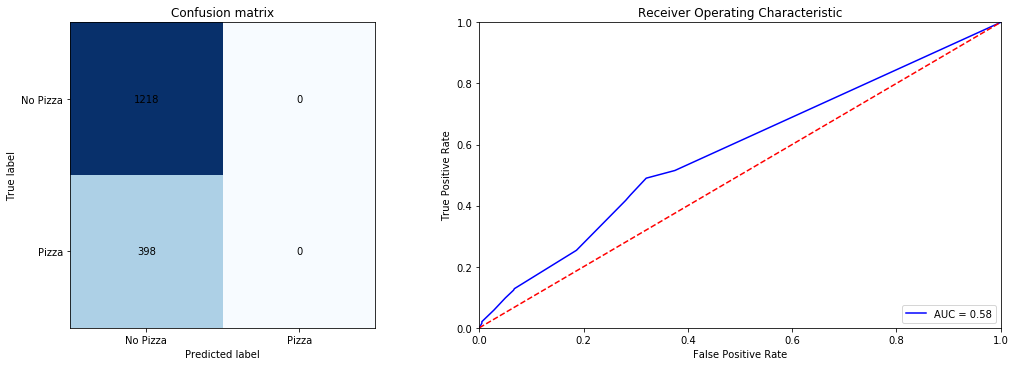

In [124]:
standard_output(labels_in = dev_labels, pred_prob_in = xgb_dev_prob, pred_class_in = xgb_dev_prob.astype(int))

<a id="featengg"></a>

## 5. Feature Engineering

### 5.1 Time

A. 'During Initial Period': 

The first two graphs in the Time Section indicate that during the initial period of the group, there was a burst of requests and an unsustained high rate of fulfillment. This doesn't align with the general trend. It might be interesting to analyze the differences between the Initial_period (Until July 2011) vs Not_Initial Period. 

In [42]:
cutoff_date = datetime.date(2011,7,31) #Cutting off on July 31
cutoff_time = time.mktime(cutoff_date.timetuple())
train_df['during_initial_period'] = np.where(train_df['unix_timestamp_of_request_utc'] < cutoff_time, 1, 0)

B. 'Time of Day' & 'Hour_of_Day': 

The third graph in the Time Section indicate that fulfillment rates oscillate between 21% & 30% based on day of the week. This isn't significant enough to be considered a distinguishing feature.

Time of the day provides an interesting variation between 6% and 38%. However posts from multiple days/ times are available for givers to select from an fulfill.  Hence this can't be used as a feature since it doesn't help us in identifying a characteristic of the Request Post. 

### 5.2 Requester Profile Variables

In [83]:
def profile_features(df_in):
    # Age of account
    median_account_age_nonzero = df_in[df_in['requester_account_age_in_days_at_request']!=0]['requester_account_age_in_days_at_request'].median()
    account_age_conditions = [
        (df_in.loc[:,'requester_account_age_in_days_at_request']==0),
        (df_in.loc[:,'requester_account_age_in_days_at_request']<=median_account_age_nonzero),
        (df_in.loc[:,'requester_account_age_in_days_at_request']>median_account_age_nonzero)]
    account_age_choices = ['throwaway', 'new', 'old']
    df_in['account_age_cat'] = np.select(account_age_conditions, account_age_choices, default='na')
    df_in['old'] = np.where(df_in['account_age_cat']=='old', 1, 0)
    df_in['new'] = np.where(df_in['account_age_cat']=='new', 1, 0)
    df_in['throwaway'] = np.where(df_in['account_age_cat']=='throwaway', 1, 0)
    
    # Number and frequency of requests - if the requester has made requests before
    df_in['first_repeat_requester'] = np.where(df_in['requester_days_since_first_post_on_raop_at_request']==0, 'first', 'repeat')
    df_in['first_requester'] = np.where(df_in['first_repeat_requester']=='first', 1, 0)
    df_in['repeat_requester'] = np.where(df_in['first_repeat_requester']=='repeat', 1, 0)

    # Commenter
    df_in['comments_raop_cat'] = np.where(df_in['requester_number_of_comments_in_raop_at_request']==0, 'never', 'has')
    df_in['never_comments'] = np.where(df_in['comments_raop_cat']=='never', 1, 0)
    df_in['has_commented'] = np.where(df_in['comments_raop_cat']=='has', 1, 0)
    
    # Up/Down Votes
    df_in['up_plus_down_cat'] = np.where(df_in['requester_upvotes_plus_downvotes_at_request']==0, 'ignored', 'popular')
    df_in['popular'] = np.where(df_in['requester_upvotes_plus_downvotes_at_request']!=0, 1, 0)
    df_in['ignored'] = np.where(df_in['requester_upvotes_plus_downvotes_at_request']==0, 1, 0)
    # TO DO: consider using up_minus_down - not sure it gives us all too much new information
    up_minus_down_conditions = [
        (df_in.loc[:,'requester_upvotes_minus_downvotes_at_request']==0),
        (df_in.loc[:,'requester_upvotes_minus_downvotes_at_request']<0),
        (df_in.loc[:,'requester_upvotes_minus_downvotes_at_request']>0)]
    up_minus_down_choices = ['ignored', 'disliked', 'liked']
    df_in['up_minus_down_cat'] = np.select(up_minus_down_conditions, up_minus_down_choices, default='na')
    
    df_out = df_in
    
    return(df_out)

In [84]:
train_df_prof_feat = profile_features(df_in = train_df_lim)
train_df_prof_feat.head()

,requester_upvotes_plus_downvotes_at_request,requester_upvotes_minus_downvotes_at_request,requester_number_of_comments_in_raop_at_request,unix_timestamp_of_request,requester_days_since_first_post_on_raop_at_request,requester_account_age_in_days_at_request,account_age_cat,old,new,throwaway,...,first_requester,repeat_requester,comments_raop_cat,never_comments,has_commented,up_plus_down_cat,popular,ignored,up_mins_down_cat,up_minus_down_cat
1640,823,185,0,1.314814e+09,0.000000,266.021667,old,1,0,0,...,1,0,never,1,0,popular,1,0,liked,liked
1908,0,0,0,1.331681e+09,0.000000,0.000000,throwaway,0,0,1,...,1,0,never,1,0,ignored,0,1,ignored,ignored
1240,7601,2479,4,1.354396e+09,165.546227,522.582060,old,1,0,0,...,0,1,has,0,1,popular,1,0,liked,liked
584,0,0,0,1.366745e+09,0.000000,0.000000,throwaway,0,0,1,...,1,0,never,1,0,ignored,0,1,ignored,ignored
3011,42,2,0,1.310808e+09,0.000000,52.056678,new,0,1,0,...,1,0,never,1,0,popular,1,0,liked,liked


#### Age of Account

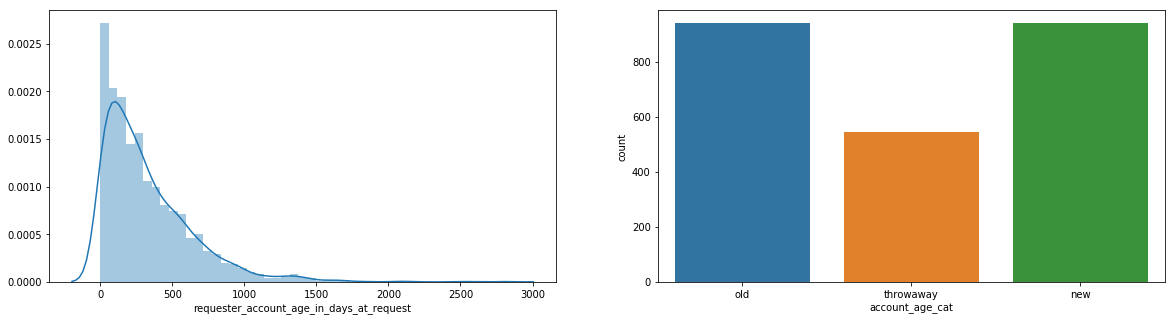

In [71]:
plt.figure(figsize=(20, 5))
# Age of account - whether it appears to be a new/throwaway account or a longtime veteran
plt.subplot(1,2,1)
sns.distplot(train_df_prof_feat.loc[train_df_prof_feat['requester_account_age_in_days_at_request']!=0, 'requester_account_age_in_days_at_request']);
# Create new variable for: first (days = 0), new (days <= median for nonzero), old (days > median for nonzero)
plt.subplot(1,2,2)
sns.countplot(x = 'account_age_cat', data = train_df_prof_feat)

#### First/Repeat Request

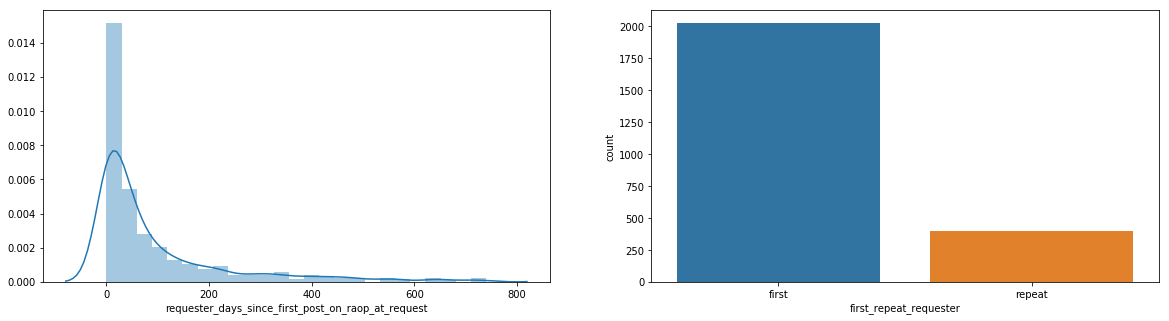

In [72]:
plt.figure(figsize=(20, 5))
# Days since request
plt.subplot(1,2,1)
sns.distplot(train_df_prof_feat.loc[train_df_prof_feat['requester_days_since_first_post_on_raop_at_request']!=0, 'requester_days_since_first_post_on_raop_at_request']);
# Create new variable for: first (days = 0), repeat (days > 0)
plt.subplot(1,2,2)
sns.countplot(x='first_repeat_requester', data = train_df_prof_feat)

#### Commenter

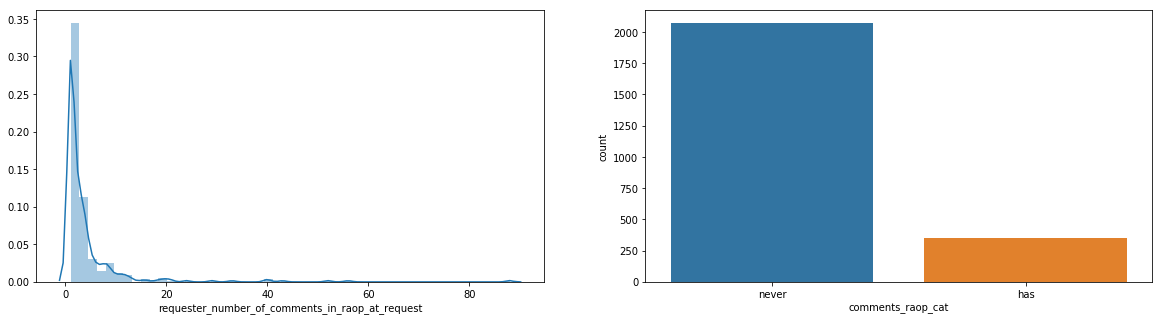

In [73]:
plt.figure(figsize=(20, 5))
# Number of RAOP comments
plt.subplot(1,2,1)
sns.distplot(train_df_prof_feat.loc[train_df_prof_feat['requester_number_of_comments_in_raop_at_request']!=0, 'requester_number_of_comments_in_raop_at_request']);
# Create new variable for: never (comments = 0), has (comments > 0)
plt.subplot(1,2,2)
sns.countplot(x = 'comments_raop_cat', data = train_df)

#### Up/Down Votes

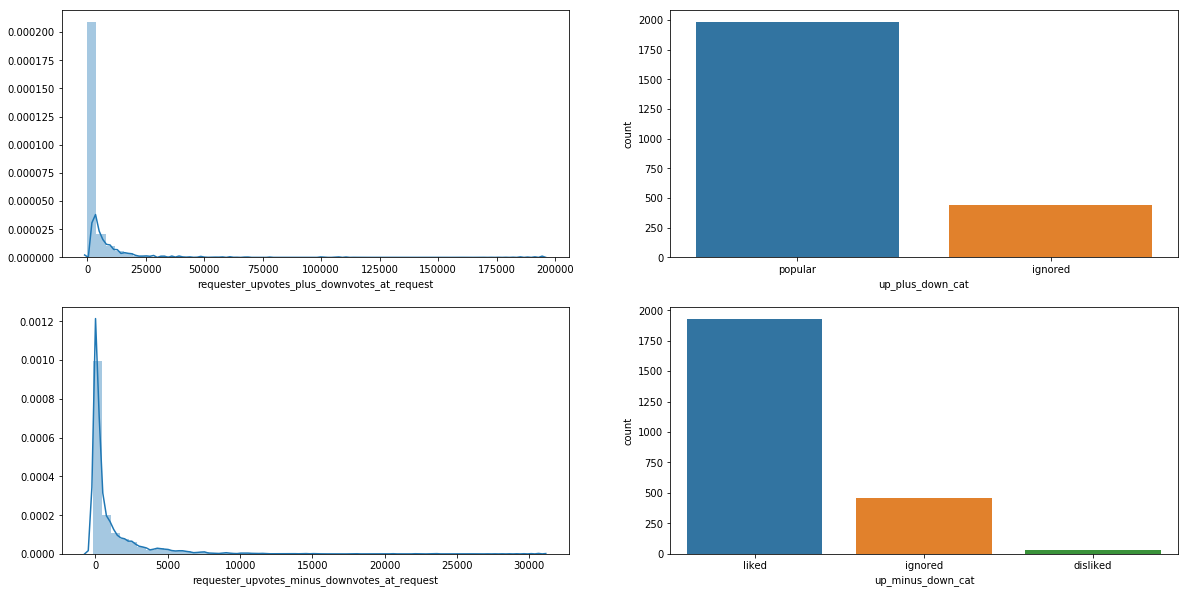

In [86]:
plt.figure(figsize=(20, 10))
# Up Plus Down
plt.subplot(2,2,1)
sns.distplot(train_df_prof_feat.loc[:,'requester_upvotes_plus_downvotes_at_request']);
# Up Plus Down Cat
plt.subplot(2,2,2)
sns.countplot(x = 'up_plus_down_cat', data = train_df_prof_feat)

# Up Minus Down
plt.subplot(2,2,3)
sns.distplot(train_df_prof_feat.loc[:,'requester_upvotes_minus_downvotes_at_request']);
# Up Minus Down Cat
plt.subplot(2,2,4)
sns.countplot(x = 'up_minus_down_cat', data = train_df_prof_feat)

### 5.3 Textual Variables

#### Text Analysis Plan (AW + SB)
* Sentiment analysis
* Check whether the post matches with the Sub-Reddits the original poster subscribed
* Number of capitalized words

Methods:  
**TO DO** - add content on each of these methods
- **Bag-of-words** = base methodology  
- Topic modelling = potential  
- Stemming/Pre-Processing = potential (see dimensionality reduction)  

### Sartaj Notes

Regarding Feature Engineering, things that could be done
- Remove special characters from request text edit aware and make it lower case
- Remove special characters from title text and make it lower case
- Concatenate request and title text
- Remove punctuation, non-alphanumeric characters and extra spaces from the combined text
- Perform stemming (Trying to shorten a word with simple regex rules) using PorterStemmer / Lemmatization (Trying to find the root word with linguistics rules (with the use of regexes)) using WordNetLemmatizer
- Image_in_text: check presence of certain words such as 'imgur.com|.jpg|.png|.jpeg' which indicates presence of images used to provide evidence of need
- Spelling Errors Ratio: ratio of spelling errors in text and title to the length of total text plus title (use the pyenchant library)

#### From the stanford paper, the part that talks about narratives

In [ ]:
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]

In [ ]:
# Work in Progress
# import string

# train_df['post_and_title'] = train_df['request_text_edit_aware'] + ' '+ train_df['request_title']
# dev_df['post_and_title'] = dev_df['request_text_edit_aware'] + ' ' + dev_df['request_title']

# def pre_process(s):
#     s = re.sub("[^\w']|_", " ", s) 
    
#     # Strip punctuation before looking
#     s = s.translate(str.maketrans(' ',' ',string.punctuation))
    
#     # Remove extra spaces
#     s = re.sub(' +',' ', s)
    
#     s = s.lower()
    
#     return s

# def find_narr(narr,s):
#     count=0
#     for word in narr:
#         count += s.split().count(word)
#     return count/len(s.split())

# def construct_narrative_features(data): 
#     data['post_and_title'] = data['request_text_edit_aware'] + ' ' + data['request_title']
#     clean_text = data['post_and_title'].apply(lambda s: pre_process(s))
    
#     features = pd.DataFrame()

#     for n in narratives:
#         features[n[0]] = clean_text.apply(lambda s: find_narr(n,s))
#     return features

# train_narrative_features = construct_narrative_features(train_df)
# dev_narrative_features = construct_narrative_features(dev_df)

##### Count the number of words capitalized

In [ ]:
## Extract the target variable and two text fields
i = 1

Y_train_np = train_df['requester_received_pizza'].values
print(Y_train_np[i])

request_text_edit_aware_train_np = train_df['request_text_edit_aware'].values
print(request_text_edit_aware_train_np[i])

request_title_train_np = train_df['request_title'].values
print(request_title_train_np[i])

requester_subreddits_at_request_train_np = train_df['requester_subreddits_at_request'].values
print(requester_subreddits_at_request_train_np[i])

In [ ]:
stateAbbrList = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
otherExlcusionList = ['US', 'PS', 'EDIT', 'PM']
capCountList = []
capCategoryList = []
for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i]
    ## Replace special characters with space
    msg = re.sub('[^1-9a-zA-Z\s]+', '', msg)
    capCount = 0
    for word in msg.split():
        ## Remove if a word has only 1 character (i.e., 'I')
        if len(word) > 1:
            if word.isupper() and word not in stateAbbrList and word not in otherExlcusionList:
                #print(word)
                capCount += 1
        
    capCountList.append(capCount)
#print(capCountList)

In [ ]:
## Avaerge target in training by the number of capitalized words
Y_byCapCount = pd.DataFrame(Y_train_np).groupby(capCountList).mean()
## Total number of observations by the number of capitalized words
n_byCapCount = pd.DataFrame(Y_train_np).groupby(capCountList).count()
print(Y_byCapCount)

fig = plt.figure()
## Specify the dimensions [left, bottom, width, height]
ax1 = fig.add_axes([0.1, 0.4, 0.8, 0.4],
                   xticklabels=[], ylim=(0, 1))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.25],
                   ylim=(0, 2000))

ax1.plot(np.unique(capCountList), Y_byCapCount)
ax1.set_ylabel('% of Pizzas Given')
ax2.hist(capCountList, 120)
ax2.set_ylabel('# of Requesters')
ax2.set_xlabel('# of Capitalized Words')

In [ ]:
## Bin into 2 categories: Capitalization (Yes, No)
capCategoryList = np.where(np.asarray(capCountList)>=1, 1, 0)

## Avaerge target in training by the number of capCategory
Y_byCapCategory = pd.DataFrame(Y_train_np).groupby(capCategoryList).mean()
## Total number of observations by the number of capCategory
n_byCapCategory = pd.DataFrame(Y_train_np).groupby(capCategoryList).count()
print(Y_byCapCategory)
print(n_byCapCategory)

##### Sentiment Analysis

In [ ]:
## Reference: https://www.nltk.org/api/nltk.sentiment.html (CITATION NEEDED)
## Reference: http://www.nltk.org/howto/sentiment.html
sid = SentimentIntensityAnalyzer()
neuList = []
posList = []
negList = []
compoundSenList = []

for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i] 
    ss = sid.polarity_scores(msg)
    neuList.append(ss['neu'])
    posList.append(ss['pos'])
    negList.append(ss['neg'])
    compoundSenList.append(ss['compound'])

In [ ]:
np.histogram(np.asarray(neuList), bins=[0, 0.25, 0.5, 0.75, 1])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#n, bins, patches = ax[1,1].hist(np.asarray(neuList), 10, density=1)
ax[0,0].hist(np.asarray(neuList))
ax[0,0].set_title('Histogram of Neutral Score')
ax[0,1].hist(np.asarray(posList))
ax[0,1].set_title('Histogram of Positive Score')
ax[1,0].hist(np.asarray(negList))
ax[1,0].set_title('Histogram of Negative Score')
ax[1,1].hist(np.asarray(compoundSenList))
ax[1,1].set_title('Histogram of Compound Score')

In [ ]:
class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [ ]:
sentimentX = np.c_[np.asarray(neuList), np.asarray(posList), np.asarray(negList), np.asarray(compoundSenList)]
#from sklearn.linear_model import LogisticRegression
lgModel = LogisticReg()
lgModel.fit(sentimentX, Y_train_np)
print(lgModel.coef_)
print(lgModel.p_values)

## Note only neutral score and compound score are significant.

##### Word Count

In [ ]:
## Count the number of words in a request text
wordCountList = []

for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i] 
    wordCountList.append(len(re.findall(r'\w+', msg)))

wordCountList_np = np.asarray(wordCountList)

## There are a few cases where word counts are less than 10, investigate more
print(np.where(wordCountList_np < 10))
print(request_text_edit_aware_train_np[18])

In [ ]:
## Scatter plot word count for each request
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_np==False], wordCountList_np[Y_train_np==False], c='black', s=1, label="Didn't Receive Pizza")
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_np==True], wordCountList_np[Y_train_np==True], c='red', s=1, label="Received Pizza")
plt.xlabel('Request Text #')
plt.ylabel('Word Count')
plt.legend()

From the scatterplot above, we cannot observe an obvious pattern whether longer request texts contribute to a higher or lower chance of getting a pizza. So we try to visualize it after sorting the word count from low to high.

In [ ]:
## Scatter plot word count for each request after sorting
srt_indices = np.argsort(wordCountList_np)
Y_train_srt = []
test = []
for i in range(len(wordCountList_np)):
    Y_train_srt.append(Y_train_np[srt_indices[i]])

wordCountList_srt_np = np.sort(wordCountList_np)
Y_train_srt_np = np.asarray(Y_train_srt)
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_srt_np==False], wordCountList_srt_np[Y_train_srt_np==False], c='black', s=1, label="Didn't Receive Pizza")
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_srt_np==True], wordCountList_srt_np[Y_train_srt_np==True], c='red', s=1, label="Received Pizza")
plt.xlabel('Sort')
plt.ylabel('Word Count')
plt.legend()

For word count is low, we see black dots more frequently. This indicates that lower word counts might result in a lower chance of getting a pizza. We plot a histogram of word count below to see whether there are natural breakpoints in word count.

In [ ]:
plt.hist(wordCountList_np, bins =100, normed=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')

The histogram seems to a mixture of three Gaussian distributions, with means around 50, 170, and 400.  
Build a 3-component Gaussian Mixture Model below:

In [ ]:
gmm = GaussianMixture(random_state=0, n_components=3)
gmm.fit(wordCountList_np.reshape(-1, 1))

wordCountCategory = gmm.predict(wordCountList_np.reshape(-1, 1))

wordCount_byWordCountCategory = pd.DataFrame(wordCountList).groupby(wordCountCategory).mean()
print('Average Word Count by GMM component:')
print(wordCount_byWordCountCategory)
print('\n')

Y_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategory).mean()
print('Percentage of requests fulfilled by GMM component:')
print(Y_byWordCountCategory)
print('\n')

n_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategory).count()
print('# of requests by GMM component:')
print(n_byWordCountCategory)

gmm_x = np.linspace(0, 900, 901)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

plt.hist(wordCountList_np, bins = 100, normed=True)
plt.plot(gmm_x, gmm_y, color="crimson", lw=2, label="GMM")
plt.legend()

Based on the average word count by GMM component, we label Component 0-2 as medium, high, and low word count category respectively. Medium and high word count requests have much higher chance of getting fulfilled than low word count requests. However, there are only 77 requests in the training set that's classified as high word count and the likelihood of receiving a pizza is not significantly different for high word count requests from medium word count requests. To avoid overfitting, we decide to group medium and high word count together.

In [ ]:
wordCountCategoryGrp_List = []
for i in range(len(wordCountCategory)):
    if (wordCountCategory[i]==0) or (wordCountCategory[i]==1):
        wordCountCategoryGrp_List.append(1)
    else:
        wordCountCategoryGrp_List.append(0)

Y_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategoryGrp_List).mean()
print('Percentage of requests fulfilled by GMM component (after grouping):')
print(Y_byWordCountCategory)
print('\n')

n_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategoryGrp_List).count()
print('# of requests by GMM component (after grouping):')
print(n_byWordCountCategory)

## 6. Models

DEV DATA Only  

Models we plan to test:
- Logistic Regression
    * **TO DO** add one sentence on algorithm methodology and potential applicability
- Naive Bayes  
- Decision Trees / Random Forest

Based on preliminary results, we will focus on the most promising model and begin to refine and tune that method.  

There are two sets of hyperparameters which we will be able to adjust in pursuit of a more accurate model:  
- **Model Parameters** _(will be dependent on which is our final model)_
    - Logistic Regression
        * `solver` - Will seek to find the optimal solver given the data size and feature dentiy (newton-cg, lbfgs, liblinear, sag, or saga)
        * `penalty` - Select norm for penalization (l1 or l2)
        * `C` - Adjust to reduce overfitting
        * `tol` & `max_iter` - Deal with convergence issues
    - Naive Bayes (BernoulliNB)
        * `alpha` - Adjust smoothing for issues with sparse data
    - Decision Trees / Random Forest
        * `max_depth` & `n_estimators` - Achieve parsimonious level of detail in the forest
        * `criterion` - Adjust method for determining the quality of each split (gini or entropy)
- **Feature Engineering Parameters**
    - Dimensionality reduction
        * `analyzer` - Find optimal unit of observation for feature creation
        * `vocabulary` - Create a more limited vocabulary using logistic regression with l1 penalty to identify and remove features with low or 0 weight
        * `min_df` - Limit reliance on rare words without losing predictive power  
        * `stop_words` - Remove overly-common words
    - Error Review
        * `pre-processor` - Create custom pre-processing algorithm to remove/edit idiosynchratic at-issue words/phrases found in review of false negatives/positives

## 7. Results

Once an optimal model has been build with training data and tested with dev data, we will run the test data through the model and output a predicted class (boolean, pizza received or not).  
This test result will be _submitted via csv to Kaggle_, which will return an accuracy score.  
This accuracy score will be compared against the benchmark ZeroR score to evaluate the predictive power of the model.